# UMAP and clustering


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from PIL import Image
import cv2
import skimage
import tifffile as tf
import os
import pandas as pd
#import napari
#print(napari.__version__)
#from dask_image.imread import imread
#import dask.array as da
#import io

import platform
if platform.system() == 'Windows':
    fileroot = 'X:/'
    print('Loading Windows')
if platform.system() == 'Linux':
    fileroot = '/home/jovyan/'
    print('Loading Linux')
if False:
    fileroot = '/home/ubuntu/Documents/'
if os.path.exists('/nfs/team283_imaging/') and not os.path.exists('/home/jovyan/'):
    fileroot = '/nfs/team283_imaging/'

colors_new=['#0072b2','#d55e00','#009e73', '#cc79a7','#f0e442','#56b4e9']

import sys
sys.path.append(fileroot+'VU_TEX/Ben_utilities/')
import useful_functions as uf
#import numba_funcs as nf

Loading Linux


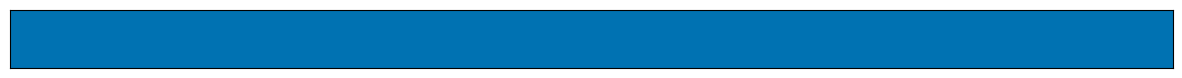

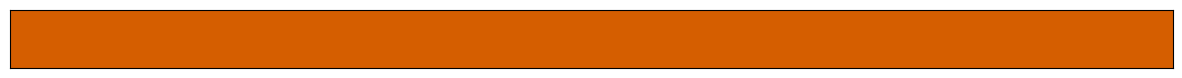

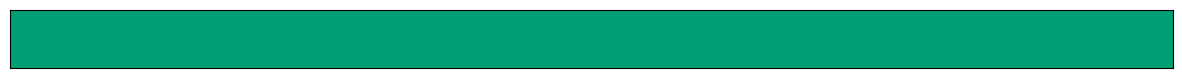

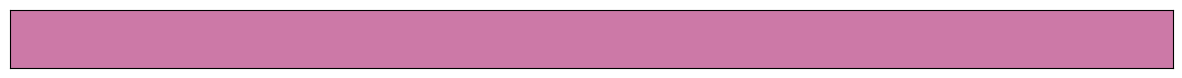

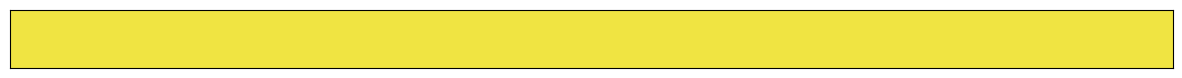

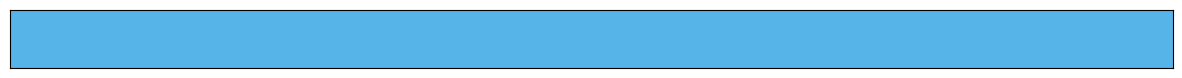

In [2]:
for i, each in enumerate(colors_new):
#    print(i)
    uf.make_Ramp_flexible([each, each])
    plt.show()

In [3]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from copy import deepcopy
from tqdm import tqdm, trange
from matplotlib.colors import to_rgba, to_hex
import hdbscan
import umap
from tqdm import tqdm, trange
import fastremap
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from numba import njit
import scipy
import pickle
from datetime import datetime

In [4]:
import seaborn as sns
Image.MAX_IMAGE_PIXELS = 100000000000

In [5]:
pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns', 100)

### Load data

In [6]:
#directory_images_metadata = fileroot + 'team283_imaging/' + '0ExternalData/2022-09-01_IVY_GAP/'
#directory_images_metadata = fileroot + '0ExternalData/2022-09-01_IVY_GAP/'
#filename_images_metadata = '2022-09-01_IVY_GAP_metadata.csv'
#df_images_metadata = pd.read_csv(directory_images_metadata + filename_images_metadata, index_col=0)
#df_images_metadata = df_images_metadata.loc[df_images_metadata['original_index'].isin([50, 594, 406, 418, 
#267, 290, 474, 231, 498, 217, 
#309, 544])]
#df_images_metadata
directory_originals = [fileroot + 'VU_TEX/playground_Ben/2023-07-05_Thymus/2023-07-06d_image_conversion_and_crop_to_small_version/']
filenames_originals = ['V11J11-099__Z4_FO3_01__A1_small.tif']
fullpaths_originals = [directory_originals[0] + filenames_originals[0]]

df_images_metadata = pd.DataFrame({'original_index': [0], 'output_filename':filenames_originals, 
                                 })
this_shape = skimage.io.imread(fullpaths_originals[0]).shape
df_images_metadata['image_width'] = this_shape[0]
df_images_metadata['image_height'] = this_shape[1]
df_images_metadata

,original_index,output_filename,image_width,image_height
0,0,V11J11-099__Z4_FO3_01__A1_small.tif,5539,3739


In [7]:
directory_images = fileroot + 'VU_TEX/playground_Ben/2023-07-05_Thymus/2023-07-06d_image_conversion_and_crop_to_small_version/'
#directory_annotated = fileroot + '0ExternalData/2022-09-01_IVY_GAP/2022-09-02_integer_annotations/'
#directory_annotated_rescaled = fileroot + 'VU_TEX/playground_Ben/2022-08-26_IVY_GAP/2022-11-09_Subset_optimisation_LBP_v18_patchsize_200/2022-11-09_integer_annotations_binned_patchsize_200/'

In [8]:
directory_output_masks = 'HDBScan_Output_masks/'
if not os.path.exists(directory_output_masks):
    os.mkdir(directory_output_masks)

In [9]:
#directory_colors_metadata = fileroot + 'team283_imaging/' + '0ExternalData/2022-09-01_IVY_GAP/'
#directory_colors_metadata = fileroot + '0ExternalData/2022-09-01_IVY_GAP/'
#filename_colors_metadata = '2022-09-02_colors_for_IVY_GAP.csv'
#df_colors = pd.read_csv(directory_colors_metadata + filename_colors_metadata, index_col=0)
#df_colors

In [10]:
#for i, each in enumerate(df_colors['white_first']):
#    print(i)
#    uf.make_Ramp_flexible([each, each])
#    plt.show()



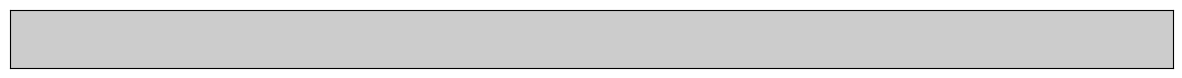

In [11]:
uf.make_Ramp_flexible([(0.8, 0.8, 0.8, 1), (0.8, 0.8, 0.8, 1)]) #0.3 is fine
plt.show()

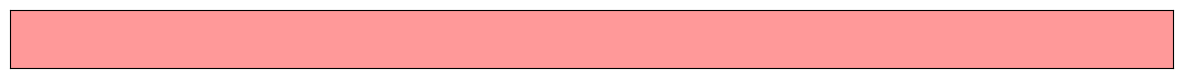

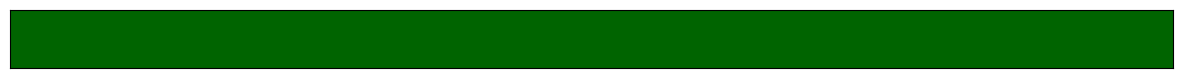

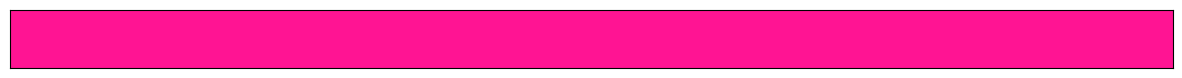

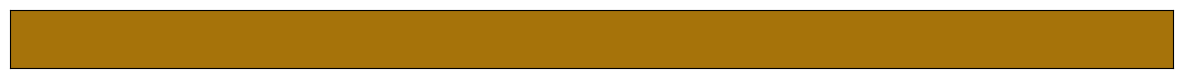

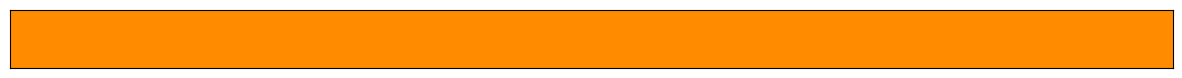

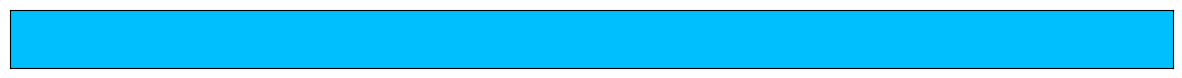

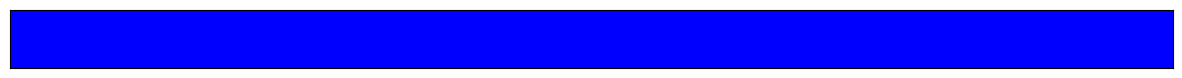

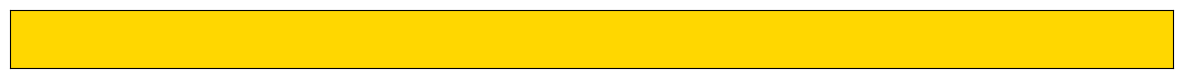

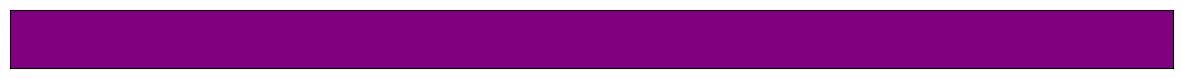

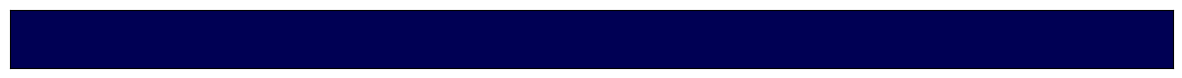

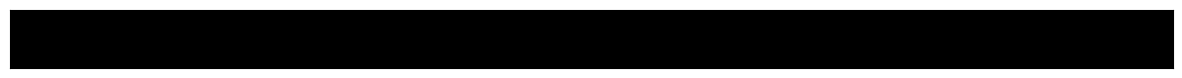

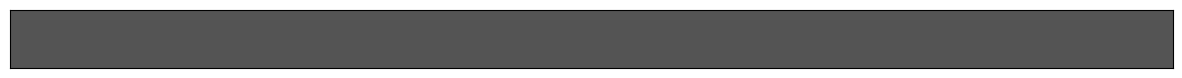

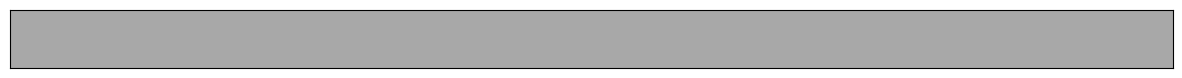

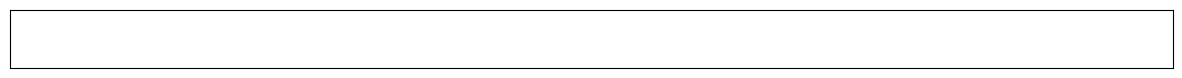

In [12]:
#mycolors = list(df_colors['white_first'])
mycolors = uf.return_color_scale('block_colors_for_labels_against_white_small_points')

In [13]:
mycolors

['#ff9999',
 '#006400',
 '#ff1493',
 '#a6730a',
 '#ff8c00',
 '#00bfff',
 '#0000ff',
 '#ffd700',
 '#800080',
 '#000054',
 '#000000',
 '#545454',
 '#a8a8a8',
 '#ffffff']

In [14]:
gray = (0.6, 0.6, 0.6)

In [15]:
dict_colors = {-1:to_rgba(gray),
    0:to_rgba(mycolors[0]), 
               1:to_rgba(mycolors[1]), 
               2:to_rgba(mycolors[2]),
               3:to_rgba(mycolors[3]),
               4:to_rgba(mycolors[4]),
               5:to_rgba(mycolors[5]),
               6:to_rgba(mycolors[6]),
               7:to_rgba(mycolors[7]),
               8:to_rgba(mycolors[8]),
               9:to_rgba(mycolors[9]),
              np.nan:(1, 1, 1)
              }

dict_color_names = {0:mycolors[0], 
               1:mycolors[1], 
               2:mycolors[2],
               3:mycolors[3],
               4:mycolors[4],
                5:mycolors[5],
               6:mycolors[6],
                7:mycolors[7],
               8:mycolors[8],
                  9:mycolors[9],  
              np.nan:(1, 1, 1)
                   }



In [16]:
#directory_X = fileroot + 'VU_TEX/playground_Ben/2022-08-26_IVY_GAP/2022-09-23_LBP_tiled_pipeline/'
#filename_X = '2022-10-13_LBP_all_images_data_X_up_to_radius_34.npy'
#X = np.load(directory_X + filename_X, mmap_mode='r')

In [17]:
directory_X_scaled = ''
#directory_X_scaled = '/lustre/scratch117/cellgen/team283/bw17/VU_TEX/playground_Ben/2022-08-26_IVY_GAP/2022-09-23_LBP_tiled_pipeline/'
filename_X_scaled = '2023-07-07_LBP_all_images_data_X.npy'
X = np.load(directory_X_scaled + filename_X_scaled, mmap_mode='r')
X.shape, X.dtype

((2035, 6051), dtype('uint16'))

In [18]:
directory_VAR = ''
filename_VAR = '2023-07-07_LBP_all_images_data_VAR.csv'
df_VAR = pd.read_csv(directory_VAR + filename_VAR, index_col=0)
df_VAR.index = df_VAR.index.astype(str)
df_VAR

,0
0,Ch_0_METHOD_uniform_npoints_7_radius_1_value_0
1,Ch_0_METHOD_uniform_npoints_7_radius_1_value_1
2,Ch_0_METHOD_uniform_npoints_7_radius_1_value_2
3,Ch_0_METHOD_uniform_npoints_7_radius_1_value_3
4,Ch_0_METHOD_uniform_npoints_7_radius_1_value_4
...,...
6046,Ch_2_METHOD_uniform_npoints_497_radius_79_valu...
6047,Ch_2_METHOD_uniform_npoints_497_radius_79_valu...
6048,Ch_2_METHOD_uniform_npoints_497_radius_79_valu...
6049,Ch_2_METHOD_uniform_npoints_497_radius_79_valu...


In [19]:
start = datetime.now(); print(start)
directory_OBS = ''
filename_OBS = '2023-07-07_LBP_all_images_data_OBS.csv'
df_OBS = pd.read_csv(directory_OBS + filename_OBS, index_col=0)
df_OBS['Groundtruth'] = pd.Categorical(df_OBS['Groundtruth'])
df_OBS['original_index'] = pd.Categorical(df_OBS['original_index'])
df_OBS.index = df_OBS.index.astype(str)
display(df_OBS)
datetime.now()-start

2023-07-07 08:23:07.268135


,this_image_index,X0,X1,Groundtruth,original_index,output_filename
0,0,0,0,0.0,0,V11J11-099__Z4_FO3_01__A1_small.tif
1,1,0,1,0.0,0,V11J11-099__Z4_FO3_01__A1_small.tif
2,2,0,2,0.0,0,V11J11-099__Z4_FO3_01__A1_small.tif
3,3,0,3,0.0,0,V11J11-099__Z4_FO3_01__A1_small.tif
4,4,0,4,0.0,0,V11J11-099__Z4_FO3_01__A1_small.tif
...,...,...,...,...,...,...
2030,2030,54,32,0.0,0,V11J11-099__Z4_FO3_01__A1_small.tif
2031,2031,54,33,0.0,0,V11J11-099__Z4_FO3_01__A1_small.tif
2032,2032,54,34,0.0,0,V11J11-099__Z4_FO3_01__A1_small.tif
2033,2033,54,35,0.0,0,V11J11-099__Z4_FO3_01__A1_small.tif


datetime.timedelta(microseconds=20725)

In [20]:
pd.unique(df_OBS['original_index'])

[0]
Categories (1, int64): [0]

0


/opt/conda/envs/lbp3c/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/envs/lbp3c/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


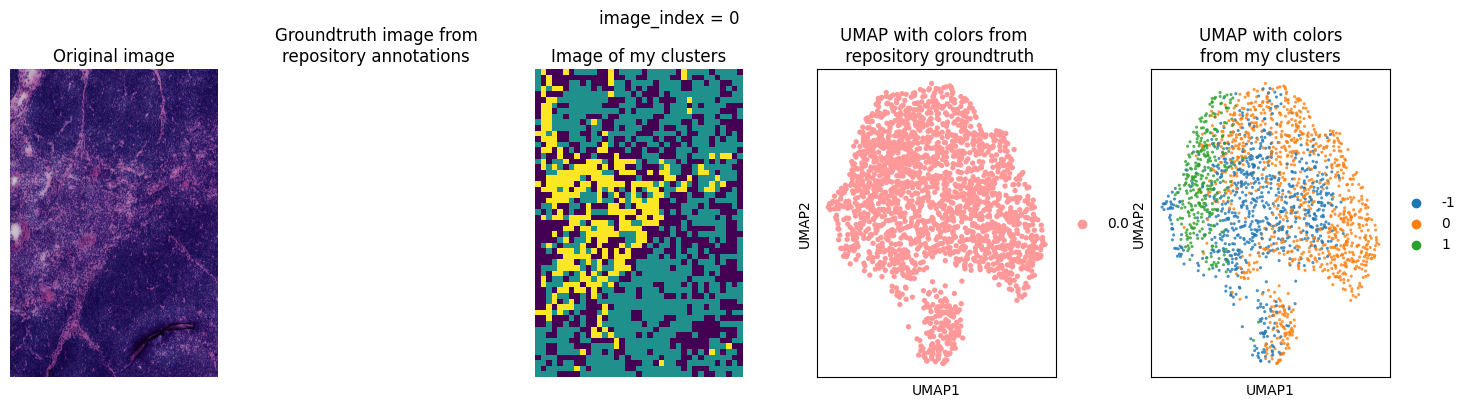

In [21]:
included_images_list = [0]
#included_images_list = [50, 594, 406, 418, 267, 290, 474, 231, 498, 217, 309, 544]

for C, this_image_index in enumerate(included_images_list):
    list_of_index_img0 = df_OBS.index[(df_OBS['original_index'].isin([this_image_index])) &
                                     (~df_OBS['Groundtruth'].isin([]))] #can add zero in here to remove the background class
    print(this_image_index)
    y = X[list_of_index_img0.astype(int)]
    anndata_concat = ad.AnnData(X=y, obs=df_OBS.loc[list_of_index_img0], var=df_VAR, dtype=np.float32)
    mycolors_list_all = anndata_concat.obs['Groundtruth'].map(dict_color_names)
    mycolors_list_all
    
    Groundtruth_vc = anndata_concat.obs['Groundtruth'].value_counts()
    anndata_concat.obs['Groundtruth'] = anndata_concat.obs['Groundtruth'].cat.set_categories(list(Groundtruth_vc.index[Groundtruth_vc > 0]))
    sc.pp.scale(anndata_concat)
    z = [dict_colors[each] for each in list(anndata_concat.obs['Groundtruth'].value_counts().index)]
    sc.tl.pca(anndata_concat, svd_solver='auto')
    sc.pp.neighbors(anndata_concat, n_neighbors=15, n_pcs=None)
    sc.tl.umap(anndata_concat) #, min_dist=0.0
    
    clusterable_embedding2 = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=20,
    random_state=42,
    ).fit_transform(anndata_concat.X)

    clusterer2 = hdbscan.HDBSCAN(min_cluster_size=300, min_samples=1, cluster_selection_epsilon=0.0,gen_min_span_tree=True)
    clusterer2.fit(clusterable_embedding2)
    anndata_concat.obs['HDBScan_UMAP_clusters'] = pd.Categorical(clusterer2.labels_)#.map({-1:-1, 0:3, 1:9})

#    original_fname_annotated = pd.unique(anndata_concat.obs['output_fname_annotated'])[0]
#    annotated = np.load(directory_annotated + original_fname_annotated.replace('.jpg', '.npy') )
#    annotated_recolor = uf.label2rgb_with_dict(annotated, dict_color_names)
#    annotated_rescaled = np.load(directory_annotated_rescaled + original_fname_annotated.replace('.jpg', '.npy') )

    dims = (np.max(anndata_concat.obs['X0']) + 1, np.max(anndata_concat.obs['X1']) + 1)
    heatmap = uf.create_heatmap_from_list_of_coords(dims, anndata_concat.obs['X0'], anndata_concat.obs['X1'], 
                                           anndata_concat.obs['HDBScan_UMAP_clusters'], scale_up = 1,
                                           bg_value=-2, dtype=np.uint8)
#    this_colors_dict = {key:value for key, value in zip(anndata_concat.obs['HDBScan_UMAP_clusters'].cat.categories,
#                                                                                        anndata_concat.uns['HDBScan_UMAP_clusters_colors'])}
#    this_colors_dict = dict_colors
#    this_colors_dict[-2] = mycolors[0]
#    heatmap_recolor = uf.label2rgb_with_dict(heatmap, this_colors_dict)
#    annotated_rescaled = annotated_rescaled[0:heatmap.shape[0], 0:heatmap.shape[1]]
#    classes_mapping_dict, overlap = uf.get_optimal_overlap_of_classes(heatmap, annotated_rescaled, 
#                                                                  elements_to_remove_from_observed = [-2, -1])
    # -2 is the class that is background I think
#    observed_classes_to_colors = {key: dict_colors[value] for key,value in classes_mapping_dict.items() if value is not np.nan}
#    observed_classes_to_colors[-2] = (1.0, 1.0, 1.0, 1.0)
#    observed_classes_to_colors[-1] = (0.3, 0.3, 0.3, 1.0)
#    remaining_classes = list(set(classes_mapping_dict.keys()) - set(observed_classes_to_colors.keys()))
#    N_rem = len(remaining_classes)
#    for i, each in enumerate(remaining_classes):
    #    observed_classes_to_colors[each] = ((i+1)/(N_rem+1), (i+1)/(N_rem+1), (i+1)/(N_rem+1), 1.0)
#        observed_classes_to_colors[each] = to_rgba(colors_new[i])
#    heatmap_recolor = uf.label2rgb_with_dict(heatmap, observed_classes_to_colors)
    heatmap_recolor = uf.label2rgb_with_dict(heatmap, dict_colors)
    
#    observed_classes_to_colors_for_umap = {key:to_hex(value) for key, value in observed_classes_to_colors.items()
#                                          if key in heatmap}
#    sorted_keys = sorted(observed_classes_to_colors_for_umap.keys())
#    sorted_keys.remove(-2)
#    anndata_concat.uns['HDBScan_UMAP_clusters_colors'] = [observed_classes_to_colors_for_umap[each] for
#                                                          each in sorted_keys]
    
    
    gridspec = dict(wspace=0.0, width_ratios=[1, 0.1, 1, 0.1, 1, 0.25, 1, 0.4, 1])
    fig, ax = plt.subplots(1,9, figsize=(18,4), gridspec_kw=gridspec) #, 
#    sc.pl.pca(anndata_concat, color='Groundtruth',
#                 size=1, palette=dict_colors, components=['1,2'], ax=ax[0], show=False,
#             title='PCA with colors\nfrom groundtruth')
    
    img_name = pd.unique(anndata_concat.obs['output_filename'])[0]
    img = skimage.io.imread(directory_images + img_name)
    ax[0].imshow(img)
    ax[0].axis('off')
    ax[0].set_title('Original image')
    sc.pl.umap(anndata_concat, color=['Groundtruth'],          
                 palette=dict_colors, show=False, alpha=1, ax=ax[6],
              title='UMAP with colors from \n repository groundtruth')
    sc.pl.umap(anndata_concat, color=['HDBScan_UMAP_clusters'], 
                 size=20, show=False, alpha=0.8, ax=ax[8],
              title='UMAP with colors\nfrom my clusters')
#    ax[2].imshow(annotated_recolor, interpolation='none')
    ax[2].axis('off')
    ax[2].set_title('Groundtruth image from\nrepository annotations')
#    ax[4].imshow(heatmap_recolor, interpolation='none')
    ax[4].imshow(heatmap, interpolation='none')
    ax[4].axis('off')
    ax[4].set_title('Image of my clusters')
    for this_ax in [ax[1], ax[3], ax[5], ax[7]]:
        this_ax.axis('off')
    plt.suptitle('image_index = ' + str(this_image_index), y=1.03)
    plt.savefig('image_index_' + str(this_image_index) + '.png', dpi=400, bbox_inches='tight', pad_inches=0.01)
    plt.show()
    
    
    np.save(directory_output_masks + 'C_' + str(C) + '_Imageindex_' + str(this_image_index) + '_ints', heatmap)
    np.save(directory_output_masks + 'C_' + str(C) + '_Imageindex_' + str(this_image_index) + '_rgb', heatmap_recolor)
#    break